<a href="https://colab.research.google.com/github/Darafarm/Darafarm/blob/main/Facemask_detection_model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd






In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
data_list = os.listdir('/content/drive/My Drive/dataset')
data_list
path = '/content/drive/My Drive/dataset'

# New Section

# New Section

In [ ]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32


In [ ]:
DIRECTORY = r'/content/drive/My Drive/dataset'
CATEGORIES = ["with_mask", "without_mask"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

[INFO] loading images...


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
data.dtype

dtype('float32')

In [ ]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
train_test_iterator = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")


In [ ]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)

headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)


In [ ]:

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
History = model.fit(
	train_test_iterator.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)



[INFO] compiling model...
[INFO] training head...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
95/95 [==============================] - 143s 1s/step - loss: 0.7088 - accuracy: 0.6150 - val_loss: 0.4648 - val_accuracy: 0.9726
Epoch 2/20
95/95 [==============================] - 147s 2s/step - loss: 0.4763 - accuracy: 0.8082 - val_loss: 0.1870 - val_accuracy: 0.9804
Epoch 3/20
95/95 [==============================] - 146s 2s/step - loss: 0.2295 - accuracy: 0.9380 - val_loss: 0.0676 - val_accuracy: 0.9831
Epoch 4/20
95/95 [==============================] - 142s 1s/step - loss: 0.1525 - accuracy: 0.9608 - val_loss: 0.0575 - val_accuracy: 0.9804
Epoch 5/20
95/95 [==============================] - 134s 1s/step - loss: 0.1120 - accuracy: 0.9713 - val_loss: 0.0398 - val_accuracy: 0.9870
Epoch 6/20
95/95 [==============================] - 137s 1s/step - loss: 0.0944 - accuracy: 0.9773 - val_loss: 0.0362 - val_accuracy: 0.9896
Epoch 7/20
95/95 [==============================] - 130s 1s/step - loss: 0.0715 - accuracy: 0.9796 - val_loss: 0.0452 - val_accuracy: 0.9831
Epoch 8/20
95

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



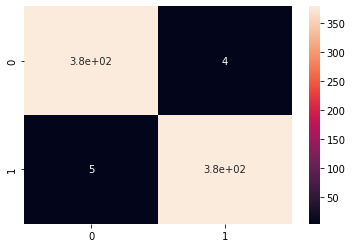

In [ ]:

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
from sklearn.metrics import confusion_matrix
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))
import seaborn as sns
sns.heatmap(confusion_matrix(testY.argmax(axis=1), predIdxs), annot = True)


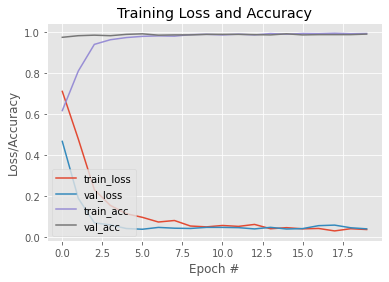

In [ ]:

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), History.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), History.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), History.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), History.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [ ]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")


[INFO] saving mask detector model...


NameError: ignored

Testing model on an unseen data 

In [4]:
import cv2
import os
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
from google.colab.patches import cv2_imshow

faceCascade = cv2.CascadeClassifier("/content/face_detection /haarcascade_frontalface_alt2.xml")
model = load_model("/content/face_detection /mask_detector.model")

def face_mask_detector(frame):
  # frame = cv2.imread(fileName)
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  faces = faceCascade.detectMultiScale(gray,
                                        scaleFactor=1.1,
                                        minNeighbors=5,
                                        minSize=(60, 60),
                                        flags=cv2.CASCADE_SCALE_IMAGE)
  faces_list=[]
  preds=[]
  for (x, y, w, h) in faces:
      face_frame = frame[y:y+h,x:x+w]
      face_frame = cv2.cvtColor(face_frame, cv2.COLOR_BGR2RGB)
      face_frame = cv2.resize(face_frame, (224, 224))
      face_frame = img_to_array(face_frame)
      face_frame = np.expand_dims(face_frame, axis=0)
      face_frame =  preprocess_input(face_frame)
      faces_list.append(face_frame)
      if len(faces_list)>0:
          preds = model.predict(faces_list)
      for pred in preds:
          (mask, withoutMask) = pred
      label = "Mask" if mask > withoutMask else "No Mask"
      color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
      label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
      cv2.putText(frame, label, (x, y- 10),
                  cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

      cv2.rectangle(frame, (x, y), (x + w, y + h),color, 3)
  # cv2_imshow(frame)
  return frame

OSError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
input_image = cv2.imread("/content/face_detection /image.jpg")
#input_image = cv2.resize(input_image, (426, 640))
output = face_mask_detector(input_image)
cv2_imshow(output)
input_image.shape

NameError: ignored

In [ ]:
import os
path = r"/content/face_detection /image.jpg"
if os.path.exists(path):
  img = cv2.imread(path)
else:
    print("Path does not exist:", path)

In [ ]:
img.shape

(900, 1200, 3)

In [ ]:
faceCascade

<CascadeClassifier 0x7f06e2607cb0>